In [7]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [8]:
#read in csv
def read_csv(path, strDate, strDateFormat):
    intSuccess = 0
    if strDateFormat != '':
        df = pd.read_csv(path, delimiter=',')
        df = df.iloc[0:35]
        df[strDate] = pd.to_datetime(datetime.strptime(df[strDate]+strDateFormat), '%Y-%m-%d')
        df.set_index(strDate, drop=True, inplace=True)

    else:
        df = pd.read_csv(path,delimiter=',',parse_dates = True,
            infer_datetime_format = True,
            index_col = strDate
            )
        df.index = pd.to_datetime(df.index, format='%Y-%m')
    if df.count != 0:
        intSuccess = 1
    return df, intSuccess

            Price   Open   High    Low     Vol. Change %
Date                                                    
2020-09-22  39.77  39.92  40.26  39.20        -    1.17%
2020-09-21  39.31  40.98  41.27  38.66   33.73K   -4.38%
2020-09-18  41.11  40.97  41.49  40.30   73.76K    0.34%
2020-09-17  40.97  40.19  41.22  39.42  280.67K    2.02%
2020-09-16  40.16  38.35  40.34  38.35  367.61K    4.91%


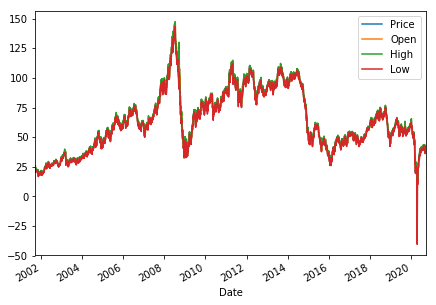

In [9]:
#read in crude price
# # print(os.path.dirname(os.getcwd()))
# base_path = os.getcwd()
# p = base_path + "\\data\\"
# print(p)
# os.chdir('')
# print(p)
strFile = 'crude_wti_futures_history_data.csv'
p = 'C:\\Users\\James McClure\\Oil_Price_Prediction\\data\\'
dfCrudePrices, intSuccess = read_csv(Path(p,strFile), 'Date', '')
if intSuccess == 1:
    print(dfCrudePrices.head())
    dfCrudePrices.plot(figsize=(7,5))
else:
    print('Tough luck sucker')

In [10]:
#get series with just oil prices
returns = (dfCrudePrices[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.head(10)

,Price
Date,
2020-09-21,-1.156651
2020-09-18,4.578988
2020-09-17,-0.340550
2020-09-16,-1.977056
2020-09-15,-4.681275
2020-09-14,-2.664577
2020-09-11,0.187869
2020-09-10,-0.080364
2020-09-09,2.010724


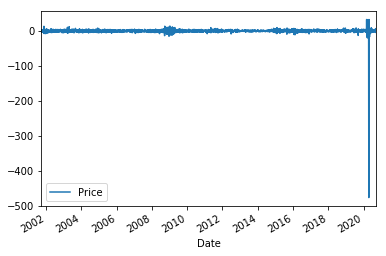

In [11]:
#plot percent price change
returns.plot()

In [12]:
from statsmodels.tsa.stattools import adfuller
print(f'Sample size = {returns.size}')
print("Augmented Dickey-Fuller")
adfuller(returns.Price)
#adFuller indicates no significant trend detected

Sample size = 4856
Augmented Dickey-Fuller


(-12.887779388516556,
 4.5155579189350985e-24,
 30,
 4825,
 {'1%': -3.4317060170726856,
  '5%': -2.8621392081311585,
  '10%': -2.567088960036511},
 32805.984368319805)

In [13]:
#remove data past 2020-2 to eliminate outliners
remove_outliners = returns.loc['2020-02':'2001-09']

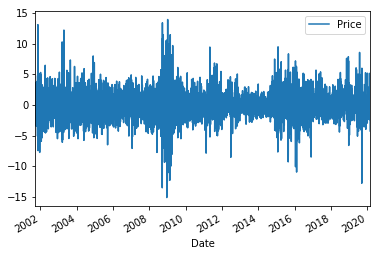

In [14]:
remove_outliners.plot()

In [15]:
print(f'Sample size = {remove_outliners.size}')
print("Augmented Dickey-Fuller")
adfuller(remove_outliners.Price)
#removed data with massive drop to determine if the dataset was more useful without it
#adFuller still indicates no significant trend detected

Sample size = 4709
Augmented Dickey-Fuller


(-14.281518971060898,
 1.321496174620928e-26,
 20,
 4688,
 {'1%': -3.4317456664346655,
  '5%': -2.8621567246115345,
  '10%': -2.56709828481003},
 21134.803075083073)

In [16]:
from statsmodels.tsa.arima_model import ARMA
# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, order=(2,1))
result1 = model.fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 4856
Model:                     ARMA(2, 1)   Log Likelihood              -16524.742
Method:                       css-mle   S.D. of innovations              7.272
Date:                Mon, 28 Sep 2020   AIC                          33059.485
Time:                        16:29:10   BIC                          33091.925
Sample:                             0   HQIC                         33070.871
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1188      0.141     -0.841      0.400      -0.395       0.158
ar.L1.y       -0.2309      0.095     -2.421      0.015      -0.418      -0.044
ar.L2.y        0.0902      0.035      2.596      0.009       0.022       0.158
ma.L1.y        0.5433      0.094      5.808      0.000       0.360       0.727
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.2873           +0.0000j            2.2873            0.5000
AR.2            4.8483           +0.0000j            4.8483            0.0000
MA.1           -1.8407           +0.0000j            1.8407            0.5000
-----------------------------------------------------------------------------
"""

In [17]:
model = ARMA(remove_outliners.values, order=(2,1))
result2 = model.fit()
result2.summary()
#removed data with massive drop to determine if the dataset was more useful without it

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 4709
Model:                     ARMA(2, 1)   Log Likelihood              -10641.777
Method:                       css-mle   S.D. of innovations              2.319
Date:                Mon, 28 Sep 2020   AIC                          21293.555
Time:                        16:29:11   BIC                          21325.841
Sample:                             0   HQIC                         21304.905
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0109      0.032      0.344      0.731      -0.051       0.073
ar.L1.y        0.6607      0.400      1.653      0.098      -0.123       1.444
ar.L2.y        0.0263      0.026      1.027      0.305      -0.024       0.077
ma.L1.y       -0.7061      0.399     -1.768      0.077      -1.489       0.077
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4318           +0.0000j            1.4318            0.0000
AR.2          -26.5321           +0.0000j           26.5321            0.5000
MA.1            1.4163           +0.0000j            1.4163            0.0000
-----------------------------------------------------------------------------
"""

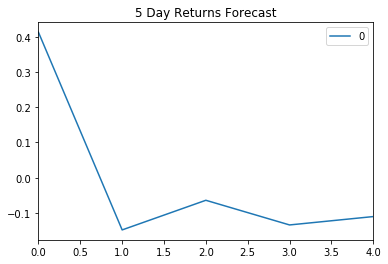

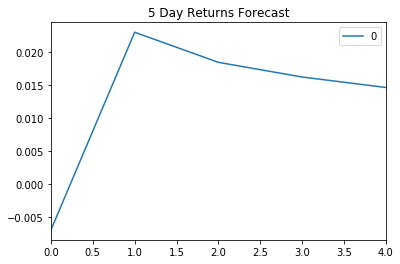

In [18]:
pd.DataFrame(result1.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")
pd.DataFrame(result2.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

In [19]:
from statsmodels.tsa.arima_model import ARIMA